In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
import seaborn as sns
import numpy as np


# The dataset

In [2]:
# loading the data
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="MedHouseVal")
df = X.join(y)

In [3]:
X.join(y).describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


<Axes: >

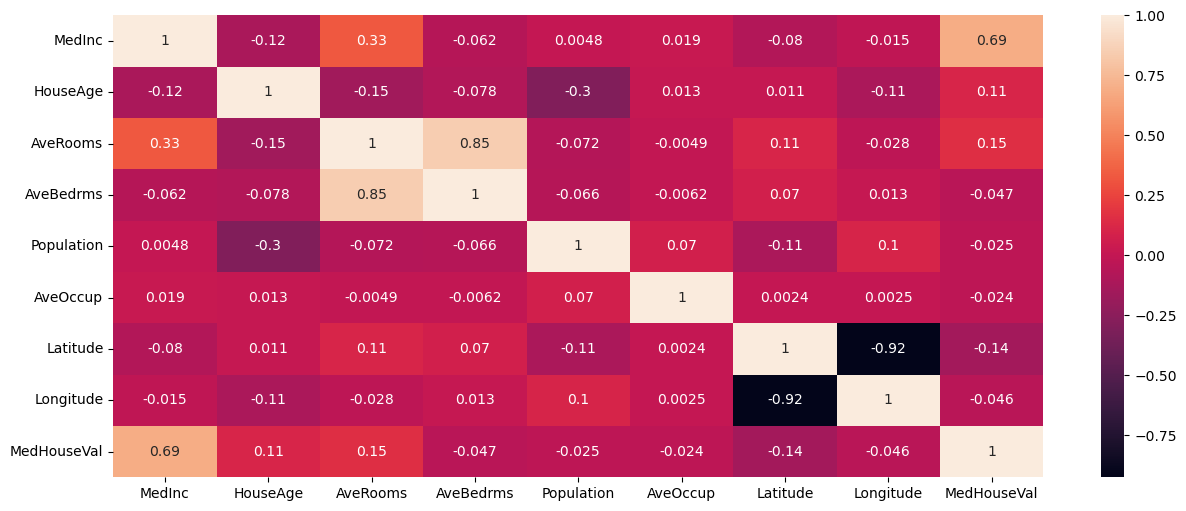

In [4]:
plt.figure(figsize=(15,6))
sns.heatmap(X.join(y).corr(),annot=True)

## About geographical features

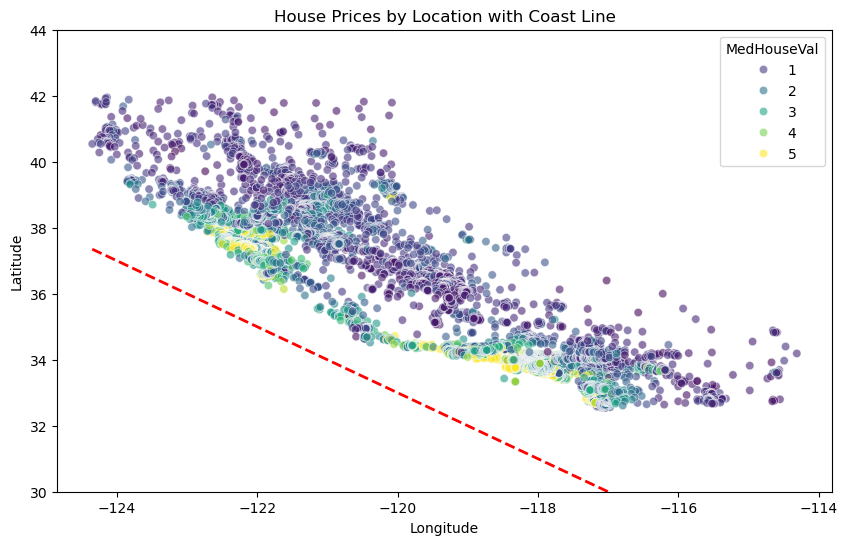

In [5]:
# Approximation of the coastline: Latitude = m * Longitude + b
m = -1   # slope
b = -87   # intercept

plt.figure(figsize=(10,6))

sns.scatterplot(x='Longitude', y='Latitude', hue='MedHouseVal', data=df, palette='viridis', alpha=0.6)

x_vals = np.array([df['Longitude'].min(), df['Longitude'].max()])
y_vals = m * x_vals + b

plt.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=2 )
plt.title("House Prices by Location with Coast Line")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.ylim(30,44)
plt.show()


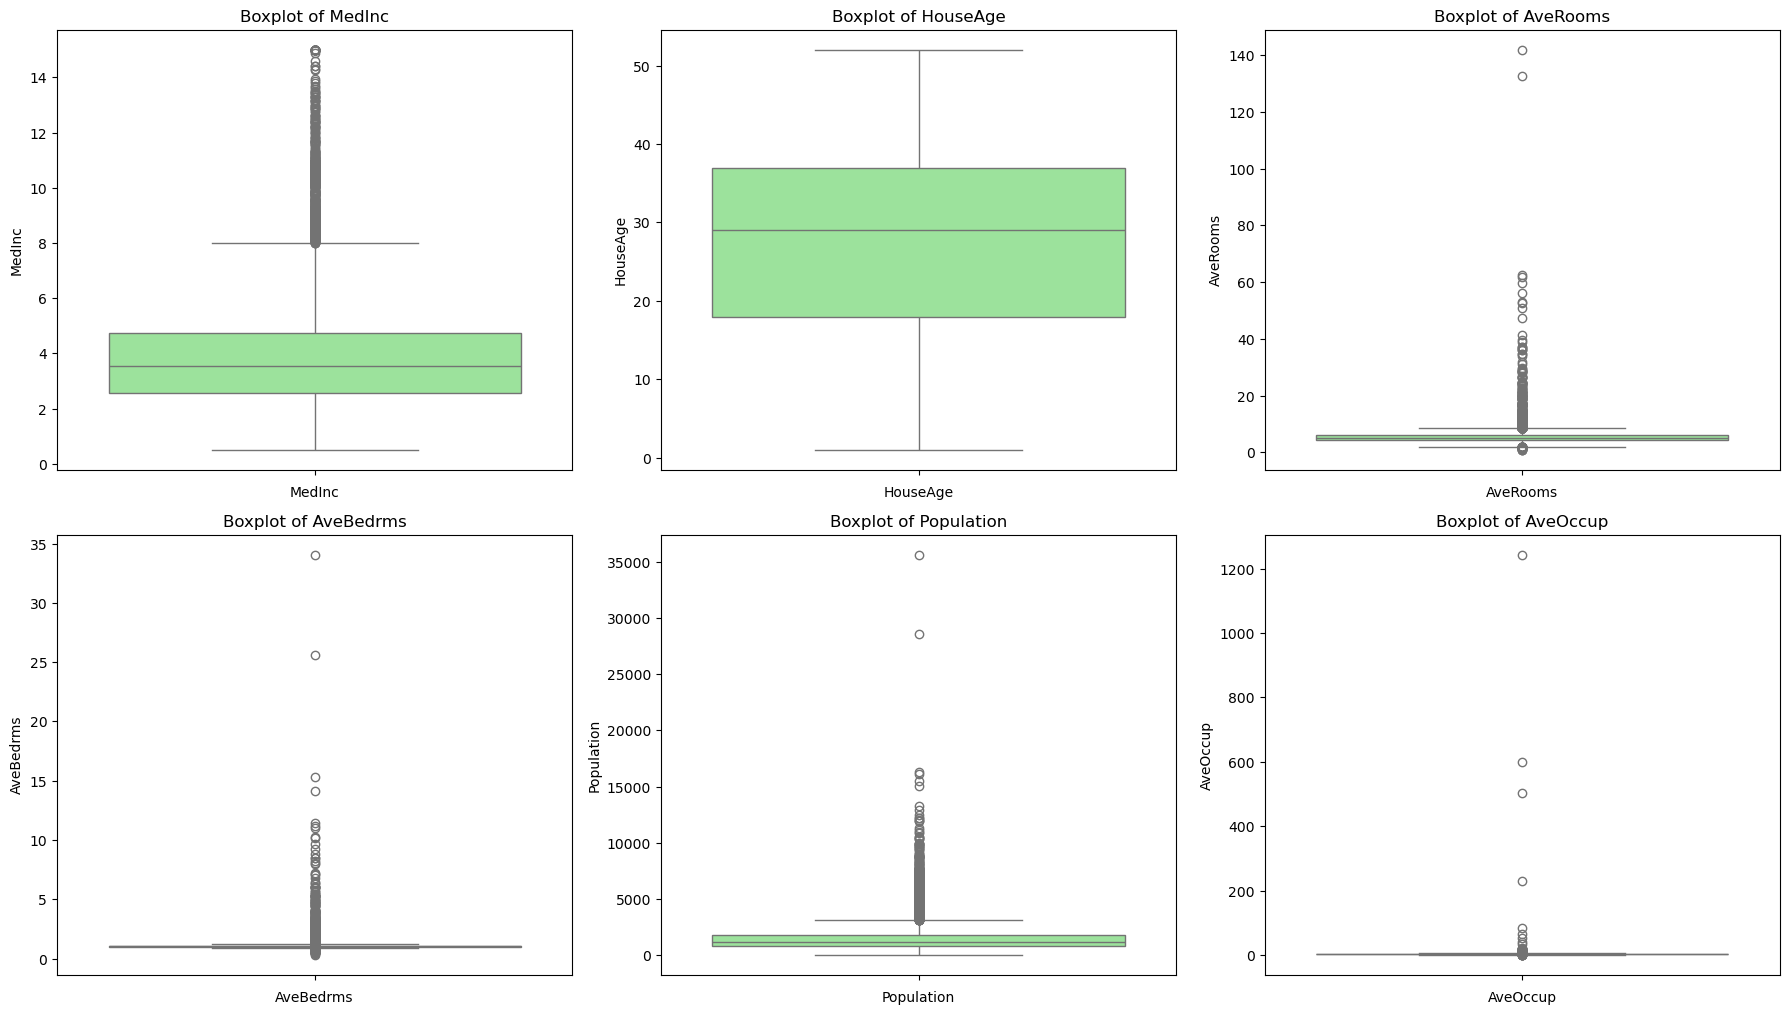

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

n_cols = 3
n_rows = 3

plt.figure(figsize=(18, 5*n_rows))

for i, f in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(y=X[f], color='lightgreen')
    plt.title(f'Boxplot of {f}')
    plt.xlabel(f)

plt.tight_layout()
plt.show()


<b style = 'color: blue'>Some blocks have very few households, which makes AveRooms and AveBedrms unusually high. These extreme values are outliers and can distort the model. To fix this, we cap the values at the 99th percentile, so anything higher is set to that limit. This keeps most of the data normal while reducing the effect of odd blocks.</b>

***
## We will *log-normalize* the skewed variables and cap the others that seem odd

In [7]:
import numpy as np
X_clean = X.copy()
# Log-transform for MedInc
X_clean['MedInc'] = np.log1p(X['MedInc'])
X_clean['Population'] = np.log1p(X['Population'])

# Capping values
cap_rooms = X['AveRooms'].quantile(0.99)
cap_bedrms = X['AveBedrms'].quantile(0.99)
cap_occ = X['AveOccup'].quantile(0.99)

# Apply capping
X_clean['AveRooms'] = X['AveRooms'].clip(upper=cap_rooms)
X_clean['AveBedrms'] = X['AveBedrms'].clip(upper=cap_bedrms)
X_clean['AveOccup'] = X['AveOccup'].clip(upper=cap_occ)


***
## Boxplot after engineering

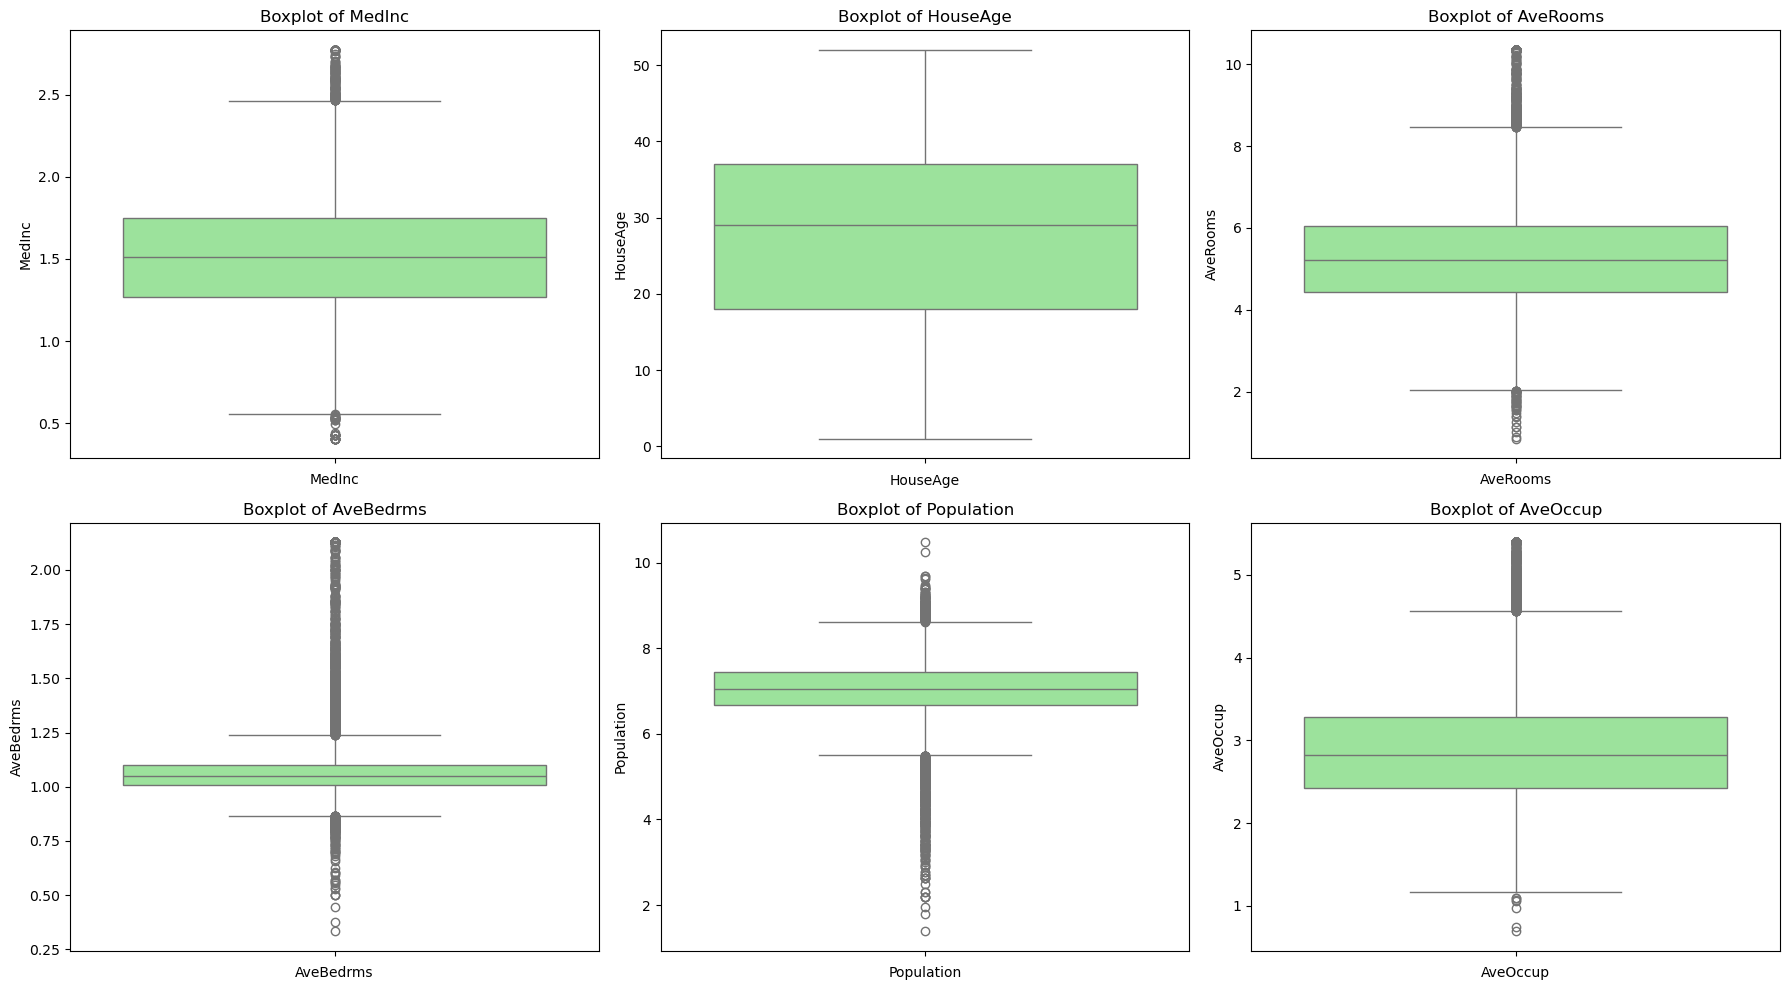

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
n_features = len(features)

# Define grid size
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # ensures enough rows

plt.figure(figsize=(18, 5*n_rows))

for i, f in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(y=X_clean[f], color='lightgreen')
    plt.title(f'Boxplot of {f}')
    plt.xlabel(f)

plt.tight_layout()
plt.show()


## Convert Longitute/Latitude into distance to coast

In [9]:
A = -m
B = 1
C = -b

X_clean['DistToCoast'] = np.abs(A * X['Longitude'] + B * X['Latitude'] + C) / np.sqrt(A**2 + B**2)
X_clean[['Longitude', 'Latitude', 'DistToCoast']].tail()


,Longitude,Latitude,DistToCoast
20635,-121.09,39.48,3.811306
20636,-121.21,39.49,3.733524
20637,-121.22,39.43,3.684026
20638,-121.32,39.43,3.613316
20639,-121.24,39.37,3.627458


In [10]:
X_clean = X_clean.drop(['Latitude', 'Longitude'], axis=1)
X_clean.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,DistToCoast
0,2.232720,41.0,6.984127,1.023810,5.777652,2.555556,1.873833
1,2.230165,21.0,6.238137,0.971880,7.784057,2.109842,1.866762
2,2.111110,52.0,8.288136,1.073446,6.208590,2.802260,1.845549
3,1.893579,52.0,5.817352,1.073059,6.326149,2.547945,1.838478
4,1.578195,52.0,6.281853,1.081081,6.338594,2.181467,1.838478


<Axes: >

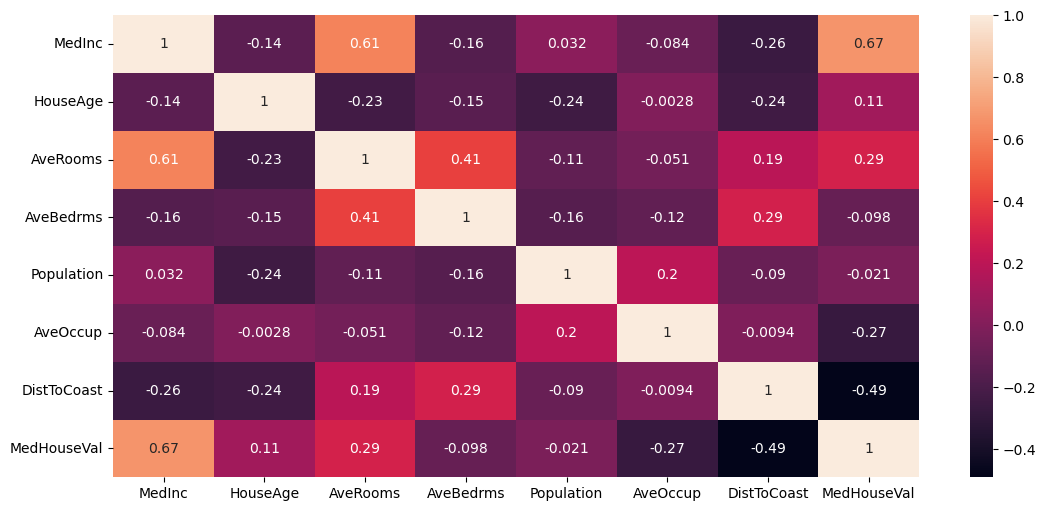

In [11]:
df = X_clean.join(y)
plt.figure(figsize=(13,6))
sns.heatmap(df.corr(), annot=True)

In [12]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,DistToCoast,MedHouseVal
0,2.232720,41.0,6.984127,1.023810,5.777652,2.555556,1.873833,4.526
1,2.230165,21.0,6.238137,0.971880,7.784057,2.109842,1.866762,3.585
2,2.111110,52.0,8.288136,1.073446,6.208590,2.802260,1.845549,3.521
3,1.893579,52.0,5.817352,1.073059,6.326149,2.547945,1.838478,3.413
4,1.578195,52.0,6.281853,1.081081,6.338594,2.181467,1.838478,3.422


***
***
# <b> Machine Learning part </b>

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2 )

## 1 - Selecting the best model

In [14]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score


models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
}

rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)  # 5-folds, repeated 3 times

cv_rmse_results = {}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=rkf)
    # Convert to RMSE
    rmse = -cv_scores.mean()
    cv_rmse_results[name] = rmse

cv_rmse_results


{'Linear Regression': np.float64(0.7081580854607197),
 'Ridge': np.float64(0.708158137788057),
 'Lasso': np.float64(1.1544925509492603),
 'Decision Tree': np.float64(0.7658142914681815),
 'Random Forest': np.float64(0.548515813869103)}

## Trying different parameters of regularization

In [15]:
from sklearn.model_selection import GridSearchCV
rkf_reg = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Ridge
ridge_search = GridSearchCV(Ridge(), 
                            param_grid={"alpha": [0.01, 0.1, 1, 10, 50, 100]}, 
                            scoring='neg_root_mean_squared_error', 
                            cv=rkf_reg)
ridge_search.fit(X_train, y_train)
print("Best Ridge alpha:", ridge_search.best_params_['alpha'])
print("Best Ridge CV RMSE:", -ridge_search.best_score_)

# Lasso
lasso_search = GridSearchCV(Lasso(max_iter=5000), 
                            param_grid={"alpha": [0.001, 0.01, 0.1, 1, 10]}, 
                            scoring='neg_root_mean_squared_error', 
                            cv=rkf)
lasso_search.fit(X_train, y_train)
print("Best Lasso alpha:", lasso_search.best_params_['alpha'])
print("Best Lasso CV RMSE:", -lasso_search.best_score_)

Best Ridge alpha: 0.1
Best Ridge CV RMSE: 0.708158002821796
Best Lasso alpha: 0.001
Best Lasso CV RMSE: 0.7082661927179335


## <b> We observe that the *Random forest* model performs the best even with the regularized linear models</b>

***
## Choosing the right parameters for the `Random Forest`

In [24]:

rf_model = RandomForestRegressor()
param_grid = {
    "n_estimators" : [90,100], 
    "max_features" : [0.5,0.8],
}

selection = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_root_mean_squared_error')

selection.fit(X_train, y_train) 

,estimator,RandomForestRegressor()
,param_grid,"{'max_features': [0.5, 0.8], 'n_estimators': [90, 100]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [25]:
best_model = RandomForestRegressor(n_estimators=100, max_features=0.5)
best_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Now let us compare all the different Risks (RMSE) for this model 

In [26]:
from sklearn.metrics import root_mean_squared_error

y_hat_train = best_model.predict(X_train)
y_hat_test = best_model.predict(X_test)

rmse_train = root_mean_squared_error(y_train, y_hat_train)
print(f"Training RMSE: {rmse_train:.4f}")

cv_scores = cross_val_score(best_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
cv_rmse = -cv_scores.mean()
print(f"Cross-Validation RMSE: {cv_rmse:.4f}")

rmse_test = root_mean_squared_error(y_test, y_hat_test)
print(f"Test RMSE: {rmse_test:.4f}")

Training RMSE: 0.1998
Cross-Validation RMSE: 0.5393
Test RMSE: 0.5313


# Deployment

In [29]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

#Ax+By+C =0 

A = 1
B = 1
C = 87

def preprocess_coastline(X):
    lon = X['Longitude'].values
    lat = X['Latitude'].values
    
    dist = np.abs(A * lon + B * lat + C) / np.sqrt(A**2 + B**2)
    
    X_rest = X.drop(['Latitude', 'Longitude'], axis=1)
    X_new = X_rest.copy()
    X_new['DistToCoast'] = dist
    
    return X_new

    
preprocess = FunctionTransformer(preprocess_coastline, validate=False)

pipe = Pipeline([
    ("prep", preprocess),
    ("rf", RandomForestRegressor(n_estimators=100, max_features=0.5))
])

from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2 )


pipe.fit(X_train_raw, y_train)


,steps,"[('prep', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,func,<function pre...x7f1ed43f0c20>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [30]:
import joblib
joblib.dump(pipe, "model/house_price_model.joblib")

['model/house_price_model.joblib']

## Testing prediction

In [ ]:
import joblib
testing_model = joblib.load("model/house_price_model.joblib")


In [32]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


# Predict a price of a house located in a certain block of California

In [39]:
columns = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 
           'AveOccup', 'Latitude', 'Longitude']

x_df = pd.DataFrame([[6.789, 40, 6.98, 1.45, 311, 3.1, 37.87, -122.22]], columns=columns)

y_pred = testing_model.predict(x_df)

print(y_pred*100000)

[243648.12]
